# All Ireland M.bovis strain diversity and clade identification

In [ ]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree, toyplot
path = '/storage/btbgenie/all_ireland_results'

## get meta data

In [248]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
print (len(meta))
meta[meta['sample'].duplicated()]

583


,sample,county,species,source,batch


## run NI

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,       
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## misc 2021 samples

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/misc_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Misc'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(app)
mask='/home/farrell/gitprojects/snipgenie/snipgenie/data/Mbovis_AF212297_mask.bed'
vcf_file='/storage/btbgenie/misc_results/snps.vcf.gz'
app.mask_filter(vcf_file, mask)

In [244]:
present=pd.read_csv('/storage/btbgenie/misc_results/summary.csv')
present['sample']=present['sample'].astype(str)
#print (present[:10])
l=list(W.fastq_table['sample'].unique())

s=meta[meta.batch>=3].sort_values(by='sample')
#s['label'] = s['sample'].apply(lambda x : x.split('-')[1][-4:]).astype(str)
#s=s.sort_values('label')

p = present[~present['sample'].isin(s['sample'])]
#p = (s[s['label'].isin(l)])
print (p)
print (len(s),len(p), len(present))

         sample                           name                                           bam_file  read_length
25  TB19-004280  TB19-004280_S68_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-004...          149
48  TB19-005887  TB19-005887_S29_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-005...          150
65 2 61


In [ ]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/misc_spoligotypes.csv')
treefile = '/storage/btbgenie/misc_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1000,tip_labels_colors=tip_colors,
                    scalebar=True,);

## run CVRL samples

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/cvrl_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/CVRL'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/cvrl_spoligotypes.csv')
treefile = '/storage/btbgenie/cvrl_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(spo['sample'],spo.SB))
colormap = trees.colors_from_labels(spo,'name','SB')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1300,tip_labels_colors=tip_colors,
                    scalebar=True,);

## integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [217]:
#read in bam files
mapped = {'wicklow':'/storage/btbgenie/wicklow_results/mapped/','cvrl':'/storage/btbgenie/cvrl_results/mapped/',
          'misc':'/storage/btbgenie/misc_results/mapped/',
                'monaghan':'/storage/btbgenie/monaghan/monaghan_results/mapped/',
                'NI':'/storage/btbgenie/NI_results/','UK':'/storage/btbgenie/UK_results/mapped'}
reload(app)
bam_files=[]
for m in mapped:
    f=app.get_files_from_paths(mapped[m], '*.bam')
    bam_files.extend(f)
print (len(bam_files))

outdir='/storage/btbgenie/all_ireland_results'
df = app.get_samples(bam_files,sep='_')
app.write_samples(df, outdir)

534


'/storage/btbgenie/all_ireland_results/samples.txt'

## run previously aligned files

In [ ]:
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/all_ireland_results', threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

## spoligotypes of all samples

In [213]:
paths = {'Wicklow':'/storage/btbgenie/mbovis_ireland/Wicklow','Monaghan':'/storage/btbgenie/mbovis_ireland/Monaghan/',
         'cvrl':'/storage/btbgenie/mbovis_ireland/CVRL',
         'NI':'/storage/btbgenie/mbovis_ireland/NI/'}
samples = []
#paths = {'misc':'/storage/btbgenie/mbovis_ireland/Jun21/'}
for p in paths:
    f = app.get_files_from_paths(paths[p])   
    df = app.get_samples(f,sep='_')
    print (len(df['sample'].unique()))
    df=df.drop_duplicates('sample')   
    df['county'] = p   
    samples.append(df)

samples = pd.concat(samples)

67


In [ ]:
reload(tools)
res=[]
for i,r in samples.iterrows():
    f=r.filename
    samp=r['sample']
    b = tools.get_spoligotype(f,1e6)
    sb = tools.get_sb_number(b)
    print (f,samp,sb, b)
    res.append([f,samp,sb,b])
    
res = pd.DataFrame(res,columns=['filename','sample','SB','code'])
res.code.astype(object)
#res.to_csv('/storage/btbgenie/all_ireland_results/spoligotypes.csv',index=False)

In [215]:
#res.to_csv('/storage/btbgenie/all_ireland_results/misc_spoligotypes.csv',index=False)

## clusters

In [219]:
def run_tree_cluster(f,dist):
    
    cmd = 'TreeCluster.py  -i {f} -t {d}'.format(f=f,d=dist)
    print (cmd)
    cl=subprocess.check_output(cmd, shell=True)
    cl=pd.read_csv(io.BytesIO(cl),sep='\t')
    return cl

res=pd.DataFrame()
for d in [0.045,0.02]:    
    cl = run_tree_cluster('%s/RAxML_bipartitions.variants' %path, d)
    res['name']=cl.SequenceName
    res[d] = cl.ClusterNumber
    
    
#print (res[0.02].value_counts())

TreeCluster.py  -i /storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants -t 0.045
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants -t 0.02


In [247]:
meta.county.value_counts()

Monaghan     191
Clare        157
Wicklow       50
NI            33
Cork          26
Meath         16
Cavan         13
Galway         9
Louth          9
Westmeath      8
Kilkenny       7
Wexford        7
Tipperary      7
Kildare        6
Kerry          6
Longford       6
Donegal        6
Laois          5
Roscommon      5
Mayo           4
Sligo          3
Offaly         3
Leitrim        1
Limerick       1
Waterford      1
Dublin         1
Name: county, dtype: int64

In [234]:
spo = pd.read_csv('/storage/btbgenie/all_ireland_results/spoligotypes.csv')
clust = pd.read_csv('/storage/btbgenie/all_ireland_results/clusters.txt',sep='\t')

In [235]:
meta = meta.merge(spo,on='sample')
meta = meta.drop('code',1)
meta = meta.merge(clust,left_on='sample',right_on='SequenceName')

In [236]:
meta[meta.county=='Cork']

,sample,county,species,source,batch,filename,SB,SequenceName,ClusterNumber
344,TB20-002800,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0140,TB20-002800,22
355,TB20-003799,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,NaN,TB20-003799,10
356,TB20-003627,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0140,TB20-003627,22
407,TB19-007867,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0141,TB19-007867,10
425,TB19-005738,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0130,TB19-005738,18
426,TB19-005737,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0130,TB19-005737,18
432,TB19-011141,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0140,TB19-011141,4
433,TB19-010956,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0140,TB19-010956,22
434,TB19-010840,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB1382,TB19-010840,18
441,TB19-009547,Cork,Cow,Declan,2.0,/storage/btbgenie/mbovis_ireland/CVRL/NGS 21-0...,SB0140,TB19-009547,4


## assign clade names?

In [237]:
clmap={}
for n,g in meta.groupby('county'):
    c = g.value_counts('ClusterNumber')
    c = c[c>10]
    for i,r in c.iteritems():
        clmap[i]=n+'-'+str(r)
clmap

{8: 'Clare-93',
 18: 'Clare-46',
 15: 'Monaghan-75',
 9: 'Monaghan-63',
 1: 'Monaghan-31',
 20: 'NI-31',
 11: 'Wicklow-46'}

In [238]:
#clmap = {5:'NI-1',7:'Wicklow-1',4:'Monaghan-1',3:'Monaghan-2',6:'Monaghan-3',-1:'Unknown',10:'Clare-1'}
meta['clade'] = meta.ClusterNumber.map(clmap)

In [58]:
meta
meta.to_csv('/storage/btbgenie/ireland_metadata.csv')

## draw all ireland tree

In [239]:
treefile = '/storage/btbgenie/all_ireland_results/tree.newick'
tre = toytree.tree(treefile)
#canvas,t,r=tre.draw(layout='c')

In [ ]:
?tre.draw

In [242]:
reload(trees)
tre = tre.root('TB20-002800')
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.clade))
#mapping['ref'] = 'AF2122/97'
tiplabels = [mapping[i] if i in mapping else 'NA' for i in tipnames]

mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
print (colormap)
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
tip_labels_style={      
        "font-size": "6px",
        "-toyplot-anchor-shift": "13px",
    }
node_sizes=[0 if i else 5 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='c',width=1200,height=1300,node_markers="o",node_hover=True, node_sizes=node_sizes,
                    tip_labels=False,tip_labels_style=tip_labels_style,node_colors=node_colors,
                    tip_labels_colors=tip_colors,scalebar=True,edge_widths=1);
#import toyplot.png
#toyplot.png.render(canvas,'/storage/btbgenie/all_ireland_results/ireland_tree.png')

{'NI': 'blue', 'Wicklow': 'green', 'Monaghan': 'crimson', 'SomewhereInNorthernIreland': 'blueviolet', 'Clare': 'orange', 'Cavan': 'cadetblue', 'Longford': 'chartreuse', 'Cork': 'chocolate', 'Louth': 'coral', 'Kilkenny': 'gold', 'Meath': 'cornflowerblue', 'Wexford': 'cornsilk', 'Kildare': 'khaki', 'Laois': 'orange', 'Roscommon': 'pink', 'Donegal': 'burlywood', 'Offaly': 'red', 'Galway': 'lime', nan: 'mediumvioletred', 'Tipperary': 'navy', 'Westmeath': 'teal', 'Sligo': 'darkblue', 'Mayo': 'purple', 'Kerry': 'orange', 'Leitrim': 'salmon', 'Limerick': 'maroon', 'Waterford': 'blue'}


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1300.0px" height="1300.0px" viewBox="0 0 1300.0 1300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t776256edffde45049da68fb071c100fa"> idx: 0
dist: 2.0015
support: 0.0000
height: 36.8103
name: TB19-006247 idx: 1
dist: 3.0032
support: 0.0000
height: 35.8087
name: TB19-006257 idx: 2
dist: 1.0007
support: 0.0000
height: 35.8149
name: TB19-003397 idx: 3
dist: 1.0007
support: 0.0000
height: 35.8149
name: TB19-006168 idx: 4
dist: 13.0489
support: 0.0000
height: 32.7849
name: TB19-005804 idx: 5
dist: 11.0395
support: 0.0000
height: 37.8143
name: TB20-005008 idx: 6
dist: 11.0447
support: 0.0000
height: 37.8091
name: TB19-004843 idx: 7
dist: 2.9665
support: 0.0000
height: 28.8739
name: TB20-001041 idx: 8
dist: 2.0315
support: 0.0000
height: 29.8089
name: TB19-004646 idx: 9
dist: 1.0317
support: 0.0000
height: 31.8087
name: TB19-003885 idx: 10
dist: 6.0057
support: 0.0000
height: 36.8204
name: TB20-007935 idx: 11
dist: 4.0041
support: 0.0000
height: 38.8220
name: TB19-005144 idx: 12
dist: 7.0063
support: 0.0000
height: 36.8234
name: TB19-000708 idx: 13
dist: 0.0048
support: 0.0000
height: 31.7758
name: TB19-011395 idx: 14
dist: 0.0048
support: 0.0000
height: 31.7758
name: TB19-008959 idx: 15
dist: 1.0003
support: 0.0000
height: 30.7852
name: TB20-011697 idx: 16
dist: 2.0011
support: 0.0000
height: 29.7892
name: TB19-011445 idx: 17
dist: 3.0028
support: 0.0000
height: 37.8107
name: TB19-000031 idx: 18
dist: 0.0048
support: 0.0000
height: 38.8041
name: TB19-003858 idx: 19
dist: 0.0048
support: 0.0000
height: 38.8041
name: TB20-001637 idx: 20
dist: 14.0711
support: 0.0000
height: 30.7725
name: TB20-007429 idx: 21
dist: 9.0322
support: 0.0000
height: 35.8114
name: TB19-004622 idx: 22
dist: 3.0042
support: 0.0000
height: 44.8369
name: TB20-001761 idx: 23
dist: 17.0766
support: 0.0000
height: 31.7603
name: TB19-005229 idx: 24
dist: 0.9998
support: 0.0000
height: 36.8149
name: TB20-013234 idx: 25
dist: 0.9996
support: 0.0000
height: 36.8151
name: TB20-007117 idx: 26
dist: 0.9996
support: 0.0000
height: 36.8199
name: TB20-011673 idx: 27
dist: 2.0017
support: 0.0000
height: 37.8229
name: TB19-000499 idx: 28
dist: 0.0048
support: 0.0000
height: 39.8197
name: TB19-001116 idx: 29
dist: 11.0375
support: 0.0000
height: 36.8000
name: TB20-012859 idx: 30
dist: 0.0048
support: 0.0000
height: 36.7829
name: TB19-011618 idx: 31
dist: 2.0011
support: 0.0000
height: 34.7866
name: TB20-002987 idx: 32
dist: 7.0164
support: 0.0000
height: 31.7919
name: TB19-004984 idx: 33
dist: 4.0037
support: 0.0000
height: 34.8046
name: TB19-008302 idx: 34
dist: 6.0092
support: 0.0000
height: 38.8293
name: TB19-004037 idx: 35
dist: 10.0302
support: 0.0000
height: 34.8083
name: 19-4281 idx: 36
dist: 23.1169
support: 0.0000
height: 26.7271
name: TB20-003818 idx: 37
dist: 21.1124
support: 0.0000
height: 33.7435
name: TB19-001492 idx: 38
dist: 0.0048
support: 0.0000
height: 29.7506
name: TB19-008949 idx: 39
dist: 4.0072
support: 0.0000
height: 25.7483
name: TB19-008952 idx: 40
dist: 1.0015
support: 0.0000
height: 31.7591
name: TB19-008951 idx: 41
dist: 1.0016
support: 0.0000
height: 31.7590
name: TB19-006007 idx: 42
dist: 1.0015
support: 0.0000
height: 31.7591
name: TB19-006006 idx: 43
dist: 1.0014
support: 0.0000
height: 31.7689
name: TB19-005970 idx: 44
dist: 6.0096
support: 0.0000
height: 42.8276
name: TB20-009522 idx: 45
dist: 9.0329
support: 0.0000
height: 35.8139
name: TB19-003881 idx: 46
dist: 6.0346
support: 0.0000
height: 38.8122
name: TB19-007739 idx: 47
dist: 12.0368
support: 0.0000
height: 33.7977
name: TB19-005570 idx: 48
dist: 1.0008
support: 0.0000
height: 

## draw trees

In [ ]:
reload(trees)
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
treefile = '/storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants'

def make_tree():
    
    labelmap = dict(zip(meta['name'],meta.species))
    colormap = trees.colors_from_labels(meta,'name','county')
    t,ts = trees.create_tree(treefile, 'ref', colormap=colormap)  #labelmap=labelmap
    colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
    for i in colors:
        f=ts.legend.add_face(
                TextFace(text=i,fgcolor=colors[i],fsize=28),            
                column=0)
    return t

t = make_tree()
ts=TreeStyle()
ts.scale=8000
t.render("%%inline",tree_style=ts,w=1000)

In [ ]:
t = make_tree()
#out = t.get_common_ancestor("19-4281", "19-2438", "461")
#out.delete()

In [ ]:
def color_clades(t):
    wick = t.get_common_ancestor("19-11957", "43-MBovis")
    mon = t.get_common_ancestor("19-7433", "19-6796")
    mon2 = t.get_common_ancestor("548", "2703")
    ni = t.get_common_ancestor("ERR125607","ERR125601")

    colors=['LightSteelBlue','lightgreen','lightgreen','salmon']
    for common,clr in zip([wick,mon,mon2,ni],colors):
        nodesinbranch = [node for node in common.traverse()]
        nstyle1=NodeStyle()
        nstyle1['bgcolor']=clr
        common.set_style(nstyle1)
        
color_clades(t)

In [ ]:
reload(trees)
ts=TreeStyle()
ts.scale=9000
ts.show_leaf_name = False
trees.set_nodesize(t, 40)
ts.mode = 'c'
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/all_ireland.png",tree_style=ts,w=2000)

In [ ]:
samples.county.value_counts()
print (samples)

In [ ]:
colormap = trees.colors_from_labels(spo,'sample','SB')
labelmap = dict(zip(spo['sample'],spo.SB))
t,ts = trees.create_tree(treefile, 'ref')#, colormap=colormap, labelmap=labelmap)
color_clades(t)
trees.color_leaves(t, colormap)
trees.set_tiplabels(t,labelmap)
colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
for i in colors:
       f=ts.legend.add_face(
             TextFace(text=i,fgcolor=colors[i],fsize=28),            
              column=0)

In [ ]:
ts.mode = 'c'
trees.set_nodesize(t, 10)
ts.scale=2000
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/sb_tree.png",tree_style=ts,w=2000)

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [253]:
csq = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)
#csq_ind = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq_indels.tsv')
#ind_mat = app.get_aa_snp_matrix(csq_ind)

In [254]:
mat = snp_mat

#labelmap = dict(zip(meta['name'],meta.county))
#mat = mat.rename(columns=labelmap)
#freqs = mat.sum(1)/len(mat.columns)
#freqs =freqs.rename('freq') 
#freqs.sort_values()
#freqs.hist(bins=20)

In [255]:
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [256]:
cols=['sample','county','SB','ClusterNumber','clade']
C=mat.T

C=C.merge(meta[cols],left_index=True,right_on='sample').set_index(cols).T
#print (C)
C=C[C.sum(1)>3].T
C.iloc[:4,:2]
C.to_csv('csq_snps_ireland.csv')

/usr/local/lib/python3.9/dist-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (4 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [257]:
counties = list(C.index.get_level_values(1))
sb = list(C.index.get_level_values(2))
clust = C.index.get_level_values(3)
clades = C.index.get_level_values(4)

In [ ]:
colormap1 = dict(zip(clades.unique(), trees.qcolors))
#colormap1 = {'Wicklow-1': 'green', 'Monaghan-3': 'red', np.nan: 'gray', 
#             'Monaghan-1': 'brown', 'Monaghan-2': 'burlywood', 'Unknown': 'lightblue', 'NI-1': 'blue'}
colors1 = [colormap1[i] if i in colormap1 else 'Black' for i in clades]
#make legend
import matplotlib.patches as mpatches
pts=[]
for c in colormap1:
    pts.append(mpatches.Patch(color=colormap1[c],label=c))
g=sns.clustermap(C,xticklabels=False,yticklabels=False,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors1)
g.fig.legend(handles=pts,bbox_to_anchor=(1.05, 1), )
g.savefig('/storage/btbgenie/all_ireland_results/snp_clusters.jpg')

## PCA

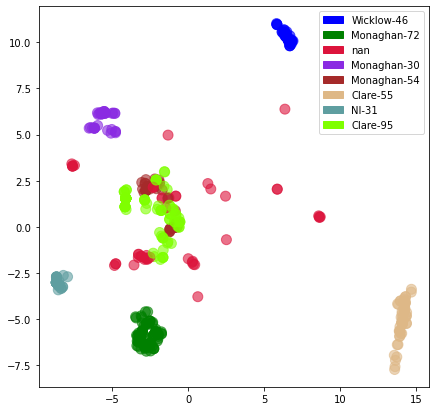

In [264]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)
df=pd.DataFrame(X)
df['sb']=sb
df.to_csv('/storage/btbgenie/all_ireland_results/pca_snp.csv')

fig,ax = plt.subplots(figsize=(7, 7))
sc=ax.scatter(X[:, 0], X[:, 1], c=colors1, s=100, alpha=.6)    
ax.legend(handles=pts,loc='best')
fig.savefig('/storage/btbgenie/all_ireland_results/pca_snp_clusters.jpg',dpi=150)